### Predicting bounding box

This notebook tries to predict the values for the upper right corner en the under left corner of the given annotated bounding boxes. We will train a CNN that tries to predict this.

In [1]:
import numpy as np
import pandas as pd
import json
import pprint
import os
import scipy.misc as spm
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [3]:
train_set = pd.read_csv('../data/validation/train.csv')
valid_set = pd.read_csv('../data/validation/test.csv')
print valid_set.head()

        filename  label
0  img_07451.jpg  OTHER
1  img_04801.jpg    YFT
2  img_07418.jpg    ALB
3  img_03965.jpg    ALB
4  img_06264.jpg    NoF


The goal is to predict the corners, where the input is **only** the image. So the class label is not known, so I create a new dataframe where there are only two thinks known. Namely, the image and the corners. Out of these images then the corners need to be predicted.

In [5]:
labeled_classes = ['ALB', 'BET', 'DOL', 'LAG', 'SHARK', 'YFT']

df = pd.DataFrame()

for label in labeled_classes:
    with open('../data/{}_labels.json'.format(label.lower())) as data_file:
        data = json.load(data_file)
        for i in range(len(data)):
            image_name = os.path.basename(data[i]['filename'])
            for box in data[i]['annotations']:
                x, y, height, width = box['x'], box['y'], box['height'], box['width']
                df[len(df.T.index)] = [image_name, x, y, height, width]
df = df.T
#print df
df.columns = ['filename', 'x', 'y', 'height', 'width']
x_temp = df[['filename']]
y_temp = df[['x', 'y', 'height', 'width']]

In [6]:
print x_temp.head()
print y_temp.head()

        filename
0  img_07917.jpg
1  img_07915.jpg
2  img_07915.jpg
3  img_07914.jpg
4  img_07912.jpg
         x       y  height    width
0  547.158  193.36  151.07  383.684
1      469     448      65      166
2       92     495     143       98
3      334     244      85      251
4      388     126     231      199


In [7]:
# loads traindata

X_train = np.zeros((train_set.shape[0], 3, 128, 128), dtype=np.uint8)
y_train = np.zeros((train_set.shape[0], 4), dtype=np.uint8)
for j in tqdm(range(train_set.shape[0])):
    arra = spm.imread(glob.glob('../data/train/*/{}'.format(train_set['filename'][j]))[0])
    warp = (128.0/arra.shape[0], 128.0/arra.shape[1])
    y_train[j,0] = int(y_temp['x'][j]*warp[1])
    y_train[j,1] = int(y_temp['y'][j]*warp[0])
    y_train[j,2] = int(y_temp['height'][j]*warp[0])
    y_train[j,3] = int(y_temp['width'][j]*warp[1])
    arra2 = spm.imresize(arra, (128,128)).transpose(2, 0, 1)
    X_train[j,:,:,:] = arra2


100%|██████████| 3021/3021 [03:21<00:00, 13.52it/s]


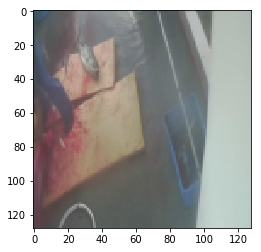

In [9]:
plt.imshow(X_train[5,:,:,:].transpose(1,2,0))
plt.plot
plt.show()

In [10]:
# loads vali data

X_valid = np.zeros((valid_set.shape[0], 3, 128, 128), dtype=np.uint8)
y_valid = np.zeros((valid_set.shape[0], 4), dtype=np.uint8)
for j in tqdm(range(valid_set.shape[0])):
    arra = spm.imread(glob.glob('../data/train/*/{}'.format(valid_set['filename'][j]))[0])
    warp = (128.0/arra.shape[0], 128.0/arra.shape[1])
    y_valid[j,0] = int(y_temp['x'][j]*warp[1])
    y_valid[j,1] = int(y_temp['y'][j]*warp[0])
    y_valid[j,2] = int(y_temp['height'][j]*warp[0])
    y_valid[j,3] = int(y_temp['width'][j]*warp[1])
    arra2 = spm.imresize(arra, (128,128)).transpose(2, 0, 1)
    X_valid[j,:,:,:] = arra2

100%|██████████| 756/756 [00:50<00:00, 14.95it/s]


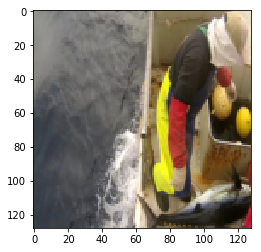

In [11]:
plt.imshow(X_valid[60,:,:,:].transpose(1,2,0))
plt.show()

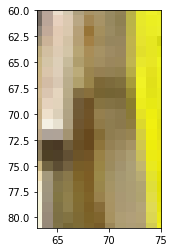

In [12]:
fig, ax = plt.subplots(1)
ax.imshow(X_valid[60,:,:,:].transpose(1,2,0))
co_x, co_y, height, width = y_valid[60,:]
plt.xlim(co_x, co_x+width)
plt.ylim(co_y+height, co_y)
plt.show()

### Running network on bounding boxes
First loading keras. 

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

n_labels = len(labels)

Using Theano backend.


#### Defining the layers of the network.

In [2]:
def keras_model_conv():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu', input_shape=(3, 128, 128)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', 'categorical_crossentropy'])

    return model

model = keras_model_conv()
model.summary()

NameError: global name 'n_labels' is not defined

In [ ]:
train_gen = datagen.flow(X_train, y_train)
val_gen = ImageDataGenerator().flow(X_val, y_val)